In [3]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import gaussian_kde
import contextily as ctx

## read data

od data in OA level

In [4]:
# read feather data
df = pd.read_feather('data/2021-10_odt.feather')

In [5]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

df['duration(mins)'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60

administritive boundary data 

In [6]:
oa_london = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/OA_2011_London_gen_MHW.shp")
oa_london = oa_london.to_crs(epsg=27700)

ward_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Ward.shp")
ward_shp = ward_shp.to_crs(epsg=27700)

borough_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")
borough_shp = borough_shp.to_crs(epsg=27700)

msoa_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp")
msoa_shp = msoa_shp.to_crs(epsg=27700)


In [7]:
oa_london_df = pd.DataFrame(oa_london)

# merge the oa_london_df with the df, use oaid_origin in df and OA11CD in oa_london_df
df_merge = pd.merge(df, oa_london_df, left_on='oaid_origin', right_on='OA11CD', how='left')
df_merge = df_merge[['index', 'oaid_origin', 'oaid_des', 'LSOA11CD','MSOA11CD','geometry','start_time', 'end_time', 'duration(mins)']]
df_merge.rename(columns={'LSOA11CD':'LSOA11CD_origin', 'MSOA11CD':'MSOA11CD_origin','geometry':'geometry_origin'}, inplace=True)

df_merge_od = pd.merge(df_merge, oa_london_df, left_on='oaid_des', right_on='OA11CD', how='left')
df_merge_od = df_merge_od[['index', 'oaid_origin', 'oaid_des', 'LSOA11CD_origin','MSOA11CD_origin','geometry_origin','start_time', 'end_time', 'duration(mins)', 'LSOA11CD','MSOA11CD','geometry']]
df_merge_od.rename(columns={'LSOA11CD':'LSOA11CD_des', 'MSOA11CD':'MSOA11CD_des','geometry':'geometry_des'}, inplace=True)


In [8]:
df_origin = df_merge_od.drop(columns=['geometry_des'])
df_des = df_merge_od.drop(columns=['geometry_origin'])

In [9]:
df_origin.sample(5)

,index,oaid_origin,oaid_des,LSOA11CD_origin,MSOA11CD_origin,geometry_origin,start_time,end_time,duration(mins),LSOA11CD_des,MSOA11CD_des
1068092,1564,E00007902,E00007903,E01001588,E02000324,"POLYGON ((542301.304 178121.034, 542388.117 17...",2021-10-14 04:51:00,2021-10-14 04:54:00,3.0,E01001588,E02000324
2952151,4622,E00024024,E00175253,E01004745,E02000980,"POLYGON ((529985.000 178762.000, 530009.737 17...",2021-10-17 11:04:00,2021-10-17 12:22:00,78.0,E01004743,E02000980
2978666,4643,E00006762,E00024081,E01001361,E02000260,"POLYGON ((512695.601 179820.201, 512692.982 17...",2021-10-18 16:45:00,2021-10-18 17:57:00,72.0,E01032513,E02000969
455539,621,E00174722,E00003041,E01033424,E02000109,"POLYGON ((518912.578 185795.452, 518912.945 18...",2021-10-14 11:34:00,2021-10-14 11:41:00,7.0,E01000635,E02000112
754439,1029,E00174934,E00005226,E01001014,E02000217,"POLYGON ((532123.000 165646.000, 532178.000 16...",2021-10-13 09:58:00,2021-10-13 10:40:00,42.0,E01001048,E02000213


In [10]:
df_merge_od['oaid_origin'].nunique()

25038

In [11]:
df_merge_od['LSOA11CD_origin'].nunique()

4835

In [12]:
df_merge_od['MSOA11CD_origin'].nunique()

983

## MSOA to PDF

1. origin

In [13]:
MSOA_Ori_Order_Count = df_origin['MSOA11CD_origin'].value_counts()
# only filter all the origin oaid that has more than 1200 numbers
MSOA_Ori_Order_Count

MSOA11CD_origin
E02000977    35398
E02000001    33193
E02000972    27715
E02000524    14684
E02000970    13427
             ...  
E02000869      803
E02000380      773
E02000414      750
E02000432      606
E02000347      588
Name: count, Length: 983, dtype: int64

In [21]:
# save the Ori_Order_Count to a list
MSOA_Ori_Order_Count_list = MSOA_Ori_Order_Count.index.tolist()
# create a new dataframe, with 80 rows and 2000 columns, fill with 0
MSOA_origin_PDFs = pd.DataFrame(np.zeros((len(MSOA_Ori_Order_Count_list), 2880)), columns=range(2880))
# add each name in the Ori_Order_Count_list to the df as the index column
MSOA_origin_PDFs.index = MSOA_Ori_Order_Count_list
MSOA_origin_PDFs

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
E02000977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02000869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# iterate throught eh ori_order_count_list, and get the corresponding rows in the df_origin
for MSOAcode in MSOA_Ori_Order_Count_list:
    data_test = df_origin[df_origin['MSOA11CD_origin'] == MSOAcode]
    # 计算'start_time'和'end_time'这两列的中间时刻，即平均时间
    data_test['mid_time'] = data_test[['start_time', 'end_time']].mean(axis=1)
    # 新建一列'hour_time',存储'mid_time'代表的分钟数，即从0点0分开始后的第几分钟，类型为数值
    data_test['hour_time'] = data_test['mid_time'].dt.hour * 60 + data_test['mid_time'].dt.minute
    # 使用高斯核密度估计（KDE），权重为 duration
    values = data_test['hour_time']
    weights = data_test['duration(mins)']
    kde = gaussian_kde(values, weights=weights)
    # 生成 x 轴范围为 0-1440 的值, 2880 为点的个数
    x = np.linspace(0, 1440, 2880)
    density = kde(x)
    # 将结果转换为 numpy 数组
    density_array = np.array(density)
    # 将密度估计结果填入索引内容为 OAcode 的那一行
    MSOA_origin_PDFs.loc[MSOAcode] = density_array

C:\Users\dune\AppData\Local\Temp\ipykernel_10880\3976123460.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['mid_time'] = data_test[['start_time', 'end_time']].mean(axis=1)
C:\Users\dune\AppData\Local\Temp\ipykernel_10880\3976123460.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['hour_time'] = data_test['mid_time'].dt.hour * 60 + data_test['mid_time'].dt.minute
C:\Users\dune\AppData\Local\Temp\ipykernel_10880\3976123460.py:5: SettingWithCopyWarning: 
A value is trying to be set 

In [ ]:
MSOA_origin_PDFs

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
E02000977,0.000279,0.000280,0.000281,0.000283,0.000284,0.000285,0.000287,0.000288,0.000289,0.000291,...,0.000387,0.000385,0.000383,0.000381,0.000379,0.000378,0.000376,0.000374,0.000372,0.000370
E02000001,0.000232,0.000233,0.000234,0.000235,0.000235,0.000236,0.000237,0.000238,0.000239,0.000240,...,0.000272,0.000271,0.000269,0.000268,0.000266,0.000265,0.000263,0.000262,0.000260,0.000259
E02000972,0.000267,0.000268,0.000270,0.000271,0.000272,0.000273,0.000274,0.000276,0.000277,0.000278,...,0.000296,0.000295,0.000293,0.000292,0.000290,0.000289,0.000287,0.000285,0.000284,0.000282
E02000524,0.000413,0.000415,0.000416,0.000417,0.000419,0.000420,0.000421,0.000423,0.000424,0.000425,...,0.000293,0.000293,0.000292,0.000291,0.000290,0.000289,0.000288,0.000287,0.000286,0.000286
E02000970,0.000313,0.000314,0.000315,0.000317,0.000318,0.000319,0.000321,0.000322,0.000323,0.000324,...,0.000190,0.000189,0.000188,0.000187,0.000186,0.000186,0.000185,0.000184,0.000183,0.000182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02000869,0.000051,0.000051,0.000051,0.000051,0.000051,0.000052,0.000052,0.000052,0.000052,0.000052,...,0.000189,0.000188,0.000187,0.000186,0.000185,0.000184,0.000184,0.000183,0.000182,0.000181
E02000380,0.000168,0.000169,0.000169,0.000169,0.000170,0.000170,0.000170,0.000171,0.000171,0.000171,...,0.000455,0.000454,0.000453,0.000452,0.000451,0.000450,0.000449,0.000448,0.000447,0.000447
E02000414,0.000172,0.000172,0.000173,0.000173,0.000174,0.000174,0.000175,0.000175,0.000176,0.000176,...,0.000122,0.000122,0.000121,0.000120,0.000120,0.000119,0.000119,0.000118,0.000118,0.000117
E02000432,0.000195,0.000196,0.000196,0.000197,0.000197,0.000198,0.000198,0.000199,0.000199,0.000200,...,0.000360,0.000360,0.000359,0.000358,0.000357,0.000356,0.000355,0.000355,0.000354,0.000353


In [43]:
MSOA_origin_PDFs.to_csv('output/MSOA_origin_PDFs.csv')

In [71]:
#read the MSOA_origin_PDFs.csv from file
MSOA_origin_PDFs_raw = pd.read_csv('output/MSOA_origin_PDFs.csv', index_col=0)

In [72]:
# normalize each row in the MSOA_origin_PDFs
MSOA_origin_PDFs = MSOA_origin_PDFs_raw.div(MSOA_origin_PDFs.sum(axis=1), axis=0)

In [73]:
# calculate the sum of first row in the MSOA_origin_PDFs
print(MSOA_origin_PDFs.iloc[0].sum())
print(MSOA_origin_PDFs.iloc[1].sum())

0.999999999999926
0.9999999999999247


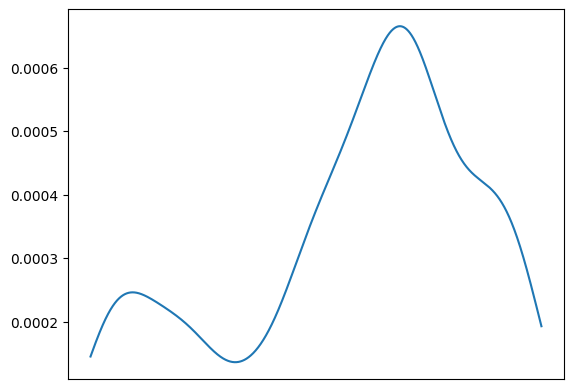

In [75]:
# plot E02000977 in MSOA_origin_PDFs
plt.plot(MSOA_origin_PDFs.loc['E02000977'])
# hide the x-axis and its label
plt.xticks([])

plt.show()

In [53]:
# save all unique values of MSOA_origin_PDFs to a list
MSOA_origin_PDFs_list = MSOA_origin_PDFs.index.tolist()
# create a data matrix with 983 rows and 983 columns, filled with 0.00, and the columns and rows are the MSOA_origin_PDFs_list
MSOA_origin_PDFs_matrix = pd.DataFrame(np.zeros((len(MSOA_origin_PDFs_list), len(MSOA_origin_PDFs_list))), columns=MSOA_origin_PDFs_list, index=MSOA_origin_PDFs_list)
MSOA_origin_PDFs_matrix

,E02000977,E02000001,E02000972,E02000524,E02000970,E02000193,E02000476,E02006801,E02000726,E02000606,...,E02006918,E02000390,E02000348,E02000734,E02000356,E02000869,E02000380,E02000414,E02000432,E02000347
E02000977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02000869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E02000432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# test the hellinger distance between E02000977 and E02000001
a=MSOA_origin_PDFs.loc['E02000977']
b=MSOA_origin_PDFs.loc['E02000001']
hellinger_distance = np.sqrt(np.sum((np.sqrt(a) - np.sqrt(b)) ** 2)) / np.sqrt(2)
hellinger_distance

0.10491870244127507

In [76]:
# for each value in the matrix, calculate the hellinger distance between the two PDF lists of these two MSOAs values
for i in MSOA_origin_PDFs_list:
    for j in MSOA_origin_PDFs_list:
        # calculate the hellinger distance between two PDF lists
        hellinger_distance = np.sqrt(np.sum((np.sqrt(MSOA_origin_PDFs.loc[i]) - np.sqrt(MSOA_origin_PDFs.loc[j])) ** 2) / np.sqrt(2))
        # fill the hellinger distance into the matrix
        MSOA_origin_PDFs_matrix.loc[i, j] = hellinger_distance
        
MSOA_origin_PDFs_matrix

,E02000977,E02000001,E02000972,E02000524,E02000970,E02000193,E02000476,E02006801,E02000726,E02000606,...,E02006918,E02000390,E02000348,E02000734,E02000356,E02000869,E02000380,E02000414,E02000432,E02000347
E02000977,0.000000,0.089725,0.052743,0.185578,0.118648,0.079990,0.208199,0.114085,0.127899,0.184108,...,0.303515,0.172299,0.227157,0.241464,0.214318,0.249034,0.136753,0.204941,0.147411,0.198121
E02000001,0.089725,0.000000,0.062908,0.216001,0.107951,0.067645,0.168558,0.091900,0.086633,0.130449,...,0.282845,0.153817,0.244473,0.252186,0.228637,0.203144,0.136389,0.185029,0.155685,0.185514
E02000972,0.052743,0.062908,0.000000,0.205472,0.108355,0.073602,0.196905,0.112685,0.119067,0.166285,...,0.311563,0.182039,0.249981,0.261048,0.233418,0.240503,0.150055,0.210528,0.164998,0.207107
E02000524,0.185578,0.216001,0.205472,0.000000,0.138125,0.152509,0.171288,0.177241,0.178693,0.186079,...,0.216739,0.159512,0.094273,0.097720,0.079989,0.243802,0.160366,0.139567,0.121479,0.252051
E02000970,0.118648,0.107951,0.108355,0.138125,0.000000,0.066466,0.141004,0.125102,0.106842,0.116449,...,0.248797,0.149333,0.187371,0.187848,0.170079,0.219827,0.151304,0.142054,0.140097,0.234449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02000869,0.249034,0.203144,0.240503,0.243802,0.219827,0.191799,0.110518,0.139884,0.134723,0.131648,...,0.155538,0.115666,0.213689,0.217557,0.194365,0.000000,0.136035,0.142906,0.148081,0.137232
E02000380,0.136753,0.136389,0.150055,0.160366,0.151304,0.106529,0.126088,0.052666,0.083383,0.130354,...,0.197315,0.069391,0.158897,0.174509,0.139330,0.136035,0.000000,0.129948,0.049397,0.096849
E02000414,0.204941,0.185029,0.210528,0.139567,0.142054,0.141046,0.107187,0.142400,0.118446,0.120260,...,0.118313,0.074388,0.103191,0.099397,0.094630,0.142906,0.129948,0.000000,0.098215,0.199183
E02000432,0.147411,0.155685,0.164998,0.121479,0.140097,0.107701,0.124233,0.085181,0.098906,0.136482,...,0.174824,0.062925,0.111901,0.128808,0.093355,0.148081,0.049397,0.098215,0.000000,0.137239


In [77]:
MSOA_origin_PDFs_matrix.to_csv('output/MSOA_origin_PDFs_matrix.csv')

In [18]:
MSOA_origin_PDFs_matrix = pd.read_csv('output/MSOA_origin_PDFs_matrix.csv', index_col=0)

In [19]:
# add a new column 'similarity_index' to the msoa_shp
msoa_shp['similarity_index'] = 0.00
# add a new column 'adjacent_ele_list' to the msoa_shp
msoa_shp['adjacent_ele_list'] = ""
msoa_shp['adjacent_2level_list'] = ""

# for each row in the msoa_shp, calculate all adjacent shapefile elements and calculate the average similarity index based on the MSOA_origin_PDFs_matrix
for index, row in msoa_shp.iterrows():
    # get tjhe MSOA code of the current row
    MSOAcode = row['MSOA11CD']
    # get the adjacent shapefile elements of the current row, which means whichever share the boundary with the current row
    adjacent = msoa_shp[msoa_shp.geometry.intersects(row['geometry'])]
    # for each element in the adjacent shapefile elements, get all the adjacent shapefile elements of them, which means the 2-level adjacent elements
    # also, the results should not contain the elements already in the adjacent shapefile elements, also exclude the current row itself
    adjacent_2level = msoa_shp[msoa_shp.geometry.intersects(adjacent['geometry'].unary_union) & ~msoa_shp.geometry.intersects(row['geometry']) & ~msoa_shp['MSOA11CD'].isin(adjacent['MSOA11CD'])]
    
    # convert the 'MSOA11CD' column of the adjacent shapefile elements to a list and save it to the 'adjacent_ele_list' column of the current row
    msoa_shp.at[index, 'adjacent_ele_list'] = adjacent['MSOA11CD'].tolist()
    # convert the 'MSOA11CD' column of the 2-level adjacent shapefile elements to a list and save it to the 'adjacent_2level_list' column of the current row
    msoa_shp.at[index, 'adjacent_2level_list'] = adjacent_2level['MSOA11CD'].tolist()
    # for each adjacent shapefile element, calculate the similarity index based on the MSOA_origin_PDFs_matrix
    similarity_index_level1 = 0
    similarity_index_level2 = 0
    for index_adj, row_adj in adjacent.iterrows():
        MSOAcode_adj = row_adj['MSOA11CD']
        similarity_index_level1 += MSOA_origin_PDFs_matrix.loc[MSOAcode, MSOAcode_adj]
        
    for index_adj, row_adj in adjacent_2level.iterrows():
        MSOAcode_adj = row_adj['MSOA11CD']
        similarity_index_level2 += MSOA_origin_PDFs_matrix.loc[MSOAcode, MSOAcode_adj]
    alpha_level1 = 1
    alpha_level2 = 0.5
    # calculate the average similarity index
    similarity_index = (similarity_index_level1 / len(adjacent)) * alpha_level1 + (similarity_index_level2 / len(adjacent_2level)) * alpha_level2
    # fill the similarity index into the msoa_shp
    msoa_shp.loc[index, 'similarity_index'] = similarity_index
    
msoa_shp.sample(4)

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,similarity_index,adjacent_ele_list,adjacent_2level_list
294,E02000302,Enfield 026,E09000010,Enfield,E12000007,London,8326,8276,50,52.7,3123,2.7,"POLYGON ((532648.885 194273.417, 532601.235 19...",0.206379,"[E02000297, E02000298, E02000302, E02000303, E...","[E02000291, E02000292, E02000293, E02000295, E..."
597,E02000619,Lambeth 002,E09000022,Lambeth,E12000007,London,8054,7987,67,146.9,3743,2.1,"POLYGON ((531111.000 179084.000, 531128.954 17...",0.143805,"[E02000619, E02000620, E02000820, E02006801, E...","[E02000621, E02000622, E02000808, E02000815, E..."
231,E02000238,Ealing 001,E09000009,Ealing,E12000007,London,9500,9381,119,62.4,3179,3.0,"POLYGON ((515276.221 185069.308, 515248.832 18...",0.126328,"[E02000238, E02000239, E02000240, E02000241, E...","[E02000100, E02000108, E02000111, E02000121, E..."
863,E02000896,Waltham Forest 002,E09000031,Waltham Forest,E12000007,London,8814,8719,95,31.3,3758,2.3,"POLYGON ((539172.688 195540.000, 539696.813 19...",0.133922,"[E02000751, E02000895, E02000896, E02000897, E...","[E02000290, E02000294, E02000754, E02000757, E..."


2. destination

In [14]:
MSOA_Des_Order_Count = df_des['MSOA11CD_des'].value_counts()
MSOA_Des_Order_Count_list = MSOA_Des_Order_Count.index.tolist()
MSOA_des_PDFs = pd.DataFrame(np.zeros((len(MSOA_Des_Order_Count_list), 2880)), columns=range(2880))
MSOA_des_PDFs.index = MSOA_Des_Order_Count_list

for MSOAcode in MSOA_Des_Order_Count_list:
    data_test = df_des[df_des['MSOA11CD_des'] == MSOAcode]
    data_test['mid_time'] = data_test[['start_time', 'end_time']].mean(axis=1)
    data_test['hour_time'] = data_test['mid_time'].dt.hour * 60 + data_test['mid_time'].dt.minute
    values = data_test['hour_time']
    weights = data_test['duration(mins)']
    kde = gaussian_kde(values, weights=weights)
    x = np.linspace(0, 1440, 2880)
    density = kde(x)
    density_array = np.array(density)
    MSOA_des_PDFs.loc[MSOAcode] = density_array
    
MSOA_des_PDFs

C:\Users\dune\AppData\Local\Temp\ipykernel_40780\1289254312.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['mid_time'] = data_test[['start_time', 'end_time']].mean(axis=1)
C:\Users\dune\AppData\Local\Temp\ipykernel_40780\1289254312.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['hour_time'] = data_test['mid_time'].dt.hour * 60 + data_test['mid_time'].dt.minute
C:\Users\dune\AppData\Local\Temp\ipykernel_40780\1289254312.py:8: SettingWithCopyWarning: 
A value is trying to be set 

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
E02000977,0.000222,0.000223,0.000224,0.000225,0.000227,0.000228,0.000229,0.000230,0.000231,0.000232,...,0.000226,0.000225,0.000224,0.000223,0.000221,0.000220,0.000219,0.000218,0.000216,0.000215
E02000001,0.000262,0.000263,0.000264,0.000265,0.000266,0.000268,0.000269,0.000270,0.000271,0.000272,...,0.000241,0.000240,0.000239,0.000238,0.000237,0.000236,0.000235,0.000234,0.000233,0.000232
E02000972,0.000243,0.000244,0.000245,0.000246,0.000248,0.000249,0.000250,0.000251,0.000252,0.000253,...,0.000252,0.000251,0.000250,0.000249,0.000248,0.000247,0.000246,0.000245,0.000244,0.000243
E02000524,0.000434,0.000435,0.000436,0.000438,0.000439,0.000440,0.000441,0.000442,0.000443,0.000445,...,0.000296,0.000295,0.000294,0.000294,0.000293,0.000292,0.000291,0.000290,0.000289,0.000288
E02000978,0.000247,0.000248,0.000249,0.000250,0.000251,0.000252,0.000253,0.000254,0.000255,0.000256,...,0.000252,0.000251,0.000250,0.000249,0.000248,0.000248,0.000247,0.000246,0.000245,0.000244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02000380,0.000151,0.000151,0.000152,0.000152,0.000152,0.000153,0.000153,0.000153,0.000153,0.000154,...,0.000293,0.000292,0.000292,0.000291,0.000290,0.000289,0.000289,0.000288,0.000287,0.000286
E02006918,0.000372,0.000372,0.000373,0.000374,0.000375,0.000376,0.000377,0.000377,0.000378,0.000379,...,0.000246,0.000245,0.000244,0.000244,0.000243,0.000243,0.000242,0.000241,0.000241,0.000240
E02000356,0.000404,0.000405,0.000405,0.000406,0.000407,0.000408,0.000409,0.000410,0.000411,0.000412,...,0.000109,0.000108,0.000108,0.000108,0.000107,0.000107,0.000107,0.000106,0.000106,0.000106
E02000347,0.000148,0.000148,0.000148,0.000149,0.000149,0.000149,0.000150,0.000150,0.000150,0.000150,...,0.000229,0.000228,0.000228,0.000227,0.000227,0.000226,0.000225,0.000225,0.000224,0.000223


In [15]:
MSOA_des_PDFs.to_csv('output/MSOA_des_PDFs.csv')

In [16]:
MSOA_des_PDFs_raw = pd.read_csv('output/MSOA_des_PDFs.csv', index_col=0)
MSOA_des_PDFs = MSOA_des_PDFs_raw.div(MSOA_des_PDFs.sum(axis=1), axis=0)

MSOA_des_PDFs_list = MSOA_des_PDFs.index.tolist()
MSOA_des_PDFs_matrix = pd.DataFrame(np.zeros((len(MSOA_des_PDFs_list), len(MSOA_des_PDFs_list))), columns=MSOA_des_PDFs_list, index=MSOA_des_PDFs_list)

for i in MSOA_des_PDFs_list:
    for j in MSOA_des_PDFs_list:
        hellinger_distance = np.sqrt(np.sum((np.sqrt(MSOA_des_PDFs.loc[i]) - np.sqrt(MSOA_des_PDFs.loc[j])) ** 2) / np.sqrt(2))
        MSOA_des_PDFs_matrix.loc[i, j] = hellinger_distance

MSOA_des_PDFs_matrix

,E02000977,E02000001,E02000972,E02000524,E02000978,E02000476,E02000193,E02000726,E02000970,E02006801,...,E02000432,E02000894,E02000428,E02006921,E02000359,E02000380,E02006918,E02000356,E02000347,E02000414
E02000977,0.000000,0.143121,0.033139,0.155924,0.107411,0.159001,0.068331,0.088236,0.074603,0.074656,...,0.188649,0.138186,0.084106,0.214496,0.288448,0.087827,0.197702,0.158127,0.123647,0.163490
E02000001,0.143121,0.000000,0.135906,0.080676,0.046557,0.114285,0.096068,0.079395,0.125738,0.083026,...,0.061005,0.048169,0.116331,0.235878,0.188412,0.113229,0.084405,0.103311,0.086856,0.092829
E02000972,0.033139,0.135906,0.000000,0.145952,0.105110,0.139922,0.059525,0.082153,0.056550,0.074757,...,0.181203,0.133093,0.088235,0.219890,0.282559,0.102825,0.194199,0.135243,0.123731,0.158872
E02000524,0.155924,0.080676,0.145952,0.000000,0.079712,0.162279,0.103348,0.125367,0.154451,0.121571,...,0.082045,0.113925,0.163318,0.298770,0.255789,0.155813,0.074086,0.131276,0.149977,0.044850
E02000978,0.107411,0.046557,0.105110,0.079712,0.000000,0.132656,0.070195,0.066655,0.112130,0.061729,...,0.086768,0.058355,0.101220,0.237109,0.223252,0.091673,0.096442,0.118309,0.091344,0.084044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02000380,0.087827,0.113229,0.102825,0.155813,0.091673,0.146443,0.087050,0.075832,0.101146,0.058898,...,0.162308,0.107724,0.047256,0.168856,0.228558,0.000000,0.171360,0.165950,0.064233,0.160792
E02006918,0.197702,0.084405,0.194199,0.074086,0.096442,0.188144,0.147729,0.148848,0.197431,0.147619,...,0.048235,0.110077,0.188161,0.307276,0.229096,0.171360,0.000000,0.160546,0.159282,0.061724
E02000356,0.158127,0.103311,0.135243,0.131276,0.118309,0.075490,0.116359,0.096413,0.105927,0.113603,...,0.123323,0.099393,0.146289,0.240567,0.208450,0.165950,0.160546,0.000000,0.128086,0.149986
E02000347,0.123647,0.086856,0.123731,0.149977,0.091344,0.095984,0.099690,0.065434,0.095614,0.062284,...,0.135035,0.075825,0.054876,0.152357,0.170738,0.064233,0.159282,0.128086,0.000000,0.163112


In [17]:
MSOA_des_PDFs_matrix.to_csv('output/MSOA_des_PDFs_matrix.csv')